In [1]:
import torch
%matplotlib inline
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms

In [2]:
# Hyperparmeters
batch_size = 128
learning_rate = 0.001

# Other constants
input_size = 28*28
num_classes = 10

In [3]:
# Download dataset
dataset = MNIST(root='data/', train=True, transform=transforms.ToTensor(), download=True)

# Training validation & test dataset
train_ds, val_ds = random_split(dataset, [50000, 10000])
test_ds = MNIST(root='data/', train=False, transform=transforms.ToTensor())

# Dataloaders
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size*2)
test_loader = DataLoader(test_ds, batch_size*2)

In [4]:
len(dataset),len(train_ds),len(test_ds)

(60000, 50000, 10000)

Label: 1


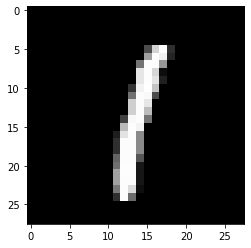

In [5]:
image, label = train_ds[0]
plt.imshow(image[0], cmap='gray')
print('Label:', label)

In [9]:
img_tensor, label = train_ds[0]
print(img_tensor.shape, label)

torch.Size([1, 28, 28]) 1


In [8]:
class MnistModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, num_classes)
        
    def forward(self, xb):
        xb = xb.reshape(-1, 784)
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
model = MnistModel()

In [10]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [11]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    optimizer = opt_func(model.parameters(), lr)
    history = [] # for recording epoch-wise results
    
    for epoch in range(epochs):
        
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)

    return history

In [12]:
result0 = evaluate(model, val_loader)
result0


{'val_loss': 2.3495941162109375, 'val_acc': 0.09941406548023224}

In [13]:
history1 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.9753, val_acc: 0.6119
Epoch [1], val_loss: 1.7001, val_acc: 0.7251
Epoch [2], val_loss: 1.4954, val_acc: 0.7617
Epoch [3], val_loss: 1.3415, val_acc: 0.7824
Epoch [4], val_loss: 1.2235, val_acc: 0.7944


In [14]:
history2 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 1.1310, val_acc: 0.8022
Epoch [1], val_loss: 1.0569, val_acc: 0.8085
Epoch [2], val_loss: 0.9964, val_acc: 0.8133
Epoch [3], val_loss: 0.9461, val_acc: 0.8186
Epoch [4], val_loss: 0.9037, val_acc: 0.8224


In [15]:
history3 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.8674, val_acc: 0.8262
Epoch [1], val_loss: 0.8359, val_acc: 0.8289
Epoch [2], val_loss: 0.8084, val_acc: 0.8314
Epoch [3], val_loss: 0.7842, val_acc: 0.8339
Epoch [4], val_loss: 0.7626, val_acc: 0.8355


In [16]:
history4 = fit(5, 0.001, model, train_loader, val_loader)

Epoch [0], val_loss: 0.7433, val_acc: 0.8378
Epoch [1], val_loss: 0.7258, val_acc: 0.8397
Epoch [2], val_loss: 0.7100, val_acc: 0.8410
Epoch [3], val_loss: 0.6956, val_acc: 0.8431
Epoch [4], val_loss: 0.6823, val_acc: 0.8448


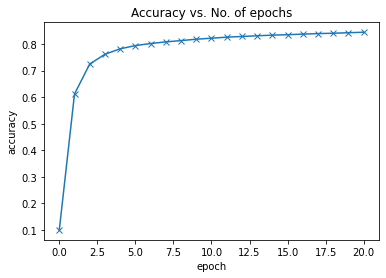

In [17]:
history = [result0] + history1 + history2 + history3 + history4
accuracies = [result['val_acc'] for result in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs');

In [18]:
# Evaluate on test dataset
result = evaluate(model, test_loader)
result

{'val_loss': 0.6400189399719238, 'val_acc': 0.8604491949081421}

In [19]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


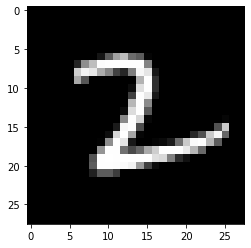

In [20]:
img, label = test_ds[919]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))

In [22]:
torch.save(model.state_dict(), 'mnist-logistic.pth')